[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ivanvladimir/Proyectos-MeIA/blob/main/Proyecto%20CNN.ipynb)
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ivanvladimir/Proyectos-MeIA/blob/main/Proyecto%20CNN.ipynb)

# Proyecto sección: Deep Learning

Esta notebook especifica el proyecto para la sesión de "Aprendizaje profundo" del grupo 3 de [Macroentrenamiento en Inteligencia Artificial](https://www.taller-tic.redmacro.unam.mx/)

Tomada dehttps://github.com/Atcold/pytorch-Deep-Learning/blob/master/03-autograd_tutorial.ipynb

## Instrucciones

1. Ejecutar toda la notebook
2. Registrar el desempeño alcanzado en el foro

## Licencia de la notebook

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a>
</br>This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

## General information

> **Author(s)**: <a href="https://twitter.com/ivanvladimir">@ivanvladimir</a></br>
> **Last updated**: 12/06/2023



# 1 Cargando librerías

En estas celdas se cargan las librerías, en particular la de [pytorch](https://pytorch.org/)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy
import os

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

# 2 Elejir el hardware

Los cálculos necesarios para una red neuronal se puden agilizar si se usa un procesador dedicado (GPU) y (TPU). Para eso depende de cadas caso de plataforma

1. En colab
   https://www.youtube.com/watch?v=TI9mTiTKoUc
2. En Kaggle
   https://www.youtube.com/watch?v=7NJGczxF714 en inglés
3. En Jupyter, es necesario tener una tarjeta gráfica y sus librerías instaladas (CUDA); en particular de tipo NVIDIA

Si no se cuenta con estas opciones, la red se ejecutará en CPU y correrá pero en algunos caso muy lento.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 3 Accedera datos (MNIST Fashion)

Estos son datos de imágnes de prendas en formato de escalas de grises y en tamaño pequeño: 28x28 pixeles: https://github.com/zalandoresearch/fashion-mnist

Estos datos ya están empaquetados para su uso; notese que se dividen entre segmentos: entrenamiento, validación y prueba.

In [23]:
input_size  = 28*28   # Definicón de tamaño de imágen: vector de 28*28 para MLP
output_size = 10      # Tamaño de la salida: vector de 10

dataset_dir = os.path.join(os.path.expanduser("~"), 'Datasets', 'FashionMNIST')
valid_ratio = 0.1  # Going to use 90%/10% split for train/valid


# Se cargan datos
train_valid_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir,
                                           train=True,
                                           transform= None, #transforms.ToTensor(),
                                           download=True)

# Se crea datos de entrenamiento y validación
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])


# Se cargan datos de prueba
test_dataset = torchvision.datasets.FashionMNIST(root=dataset_dir,
                                                 transform= None, #transforms.ToTensor(),
                                                 train=False)

class DatasetTransformer(torch.utils.data.Dataset):

    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.base_dataset[index]
        return self.transform(img), target

    def __len__(self):
        return len(self.base_dataset)

# Se prosean los datos para que queden como tensores
train_dataset = DatasetTransformer(train_dataset, transforms.ToTensor())
valid_dataset = DatasetTransformer(valid_dataset, transforms.ToTensor())
test_dataset  = DatasetTransformer(test_dataset , transforms.ToTensor())

# Se genera la estructura de datos que nos permitiŕa iterar (ciclo) en los datos
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=64, shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1000, shuffle=True)

# Visualizando algunas imágenes

Se visualizan 10 imágenes; se usa matplotlib

si se quiere cambiar la imágen cambié el índice de la imagen inicial

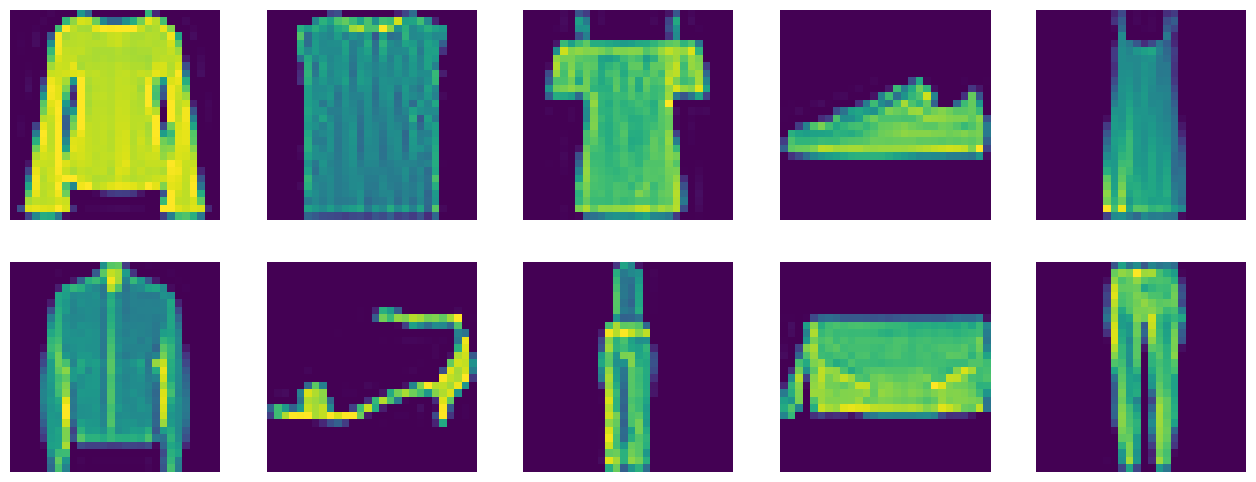

In [24]:
IMAGEN_INICIAL=300 # Cambia este número para ver otro grup de imágenes
IMAGEN_INICIAL=min(IMAGEN_INICIAL,len(train_loader)-10) # Que el indice de la inicial no sea mayor que las imágens que tenemos

# show some images
plt.figure(figsize=(16, 6))
for i in range(0,10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset[IMAGEN_INICIAL+i]
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');


# 4 Diseño de red

Se diseñan dos tipos de redes

1. FC2Layer Una red multicapa
2. CNN Una red convolucional

In [25]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        # Se usa nn.Sequential para conectar las capas una tras otra
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), # Primera capa [28*28 X n_hidden]
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden), # Segunda capa [n_hidden X n_hidden]
            nn.ReLU(),
            nn.Linear(n_hidden, output_size), # Capa de salida [n_hidden X output_size]
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        # En lugar de secuential se usa encadenamiento para definir la relación entre capas
        x = self.conv1(x) # 1. Capa Conv con n_feature kernels
        x = F.relu(x) # Función de activación
        x = F.max_pool2d(x, kernel_size=2) # 1. Pooling
        x = self.conv2(x) # 2. Capa Conv con n_feature kernels
        x = F.relu(x) # Función de activación
        x = F.max_pool2d(x, kernel_size=2) # 2. Pooling
        x = x.view(-1, self.n_feature*4*4) # Re-arreglamento del cubo a una dimensión
        x = self.fc1(x) # Primera capa de la parte del MLP
        x = F.relu(x)
        x = self.fc2(x) # Capa de salida/2a cpa de la parte de MLP
        x = F.log_softmax(x, dim=1)
        return x

## 5 Entrenamiento

Este es un ciclo de entrenamiento y de prueba definido como función

In [26]:
accuracy_list = []

# Proceso de entrenamiento
def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train() # Se prepara el modelo para que guarde gradientes
    for batch_idx, (data, target) in enumerate(train_loader):
        # Se obtiene un batch de datos y se prepara para
        data, target = data.to(device), target.to(device)

        # Se acomodan datos como vector para FC2Layer y como matriz para CNN
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        # -------------------- PASOS DE ENTRENAMIENTO --------------------
        optimizer.zero_grad() # Olvidamos gradientes pasados
        output = model(data)  # Se hace la predicción
        loss = F.nll_loss(output, target) # Se calcula el error (perdida)
        loss.backward()   # Se calculan los gradientes
        optimizer.step()  # Se hace un paso de optimización
        # -------------------- TERMINA PASOS DE ENTRENAMINTO  -------------

        # Cada 100 pasos se imprime información como va el proceso
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            loss_validation=[]
            for batch_idx, (data, target) in enumerate(validation_loader):
                  # Se obtiene un batch de datos y se prepara para
                  data, target = data.to(device), target.to(device)

                  # Se acomodan datos como vector para FC2Layer y como matriz para CNN
                  data = data.view(-1, 28*28)
                  data = data[:, perm]
                  data = data.view(-1, 1, 28, 28)
                  output = model(data)
                  loss = F.nll_loss(output, target)
                  loss_validation.append(loss.item())
            print('Validation: Loss: {:.6f}'.format(
                100. * sum(loss_validation)/len(validation_loader)))


# Cliclo de prueba, ya no se calculan gradiantes
def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [27]:
# Entrenando la MLP también conocida como Fully Connected

n_hidden = 50 # La capa intermedia tendrá este número de unidades

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 10):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 42310
Train Epoch: 0 [0/54000 (0%)]	Loss: 2.298086
Validation: Loss: 230.598967
Train Epoch: 0 [6400/54000 (12%)]	Loss: 2.083819
Validation: Loss: 209.069304
Train Epoch: 0 [12800/54000 (24%)]	Loss: 1.543262
Validation: Loss: 155.994486
Train Epoch: 0 [19200/54000 (36%)]	Loss: 1.284793
Validation: Loss: 112.329511
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.975039
Validation: Loss: 94.158308
Train Epoch: 0 [32000/54000 (59%)]	Loss: 0.836321
Validation: Loss: 85.355971
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.914869
Validation: Loss: 77.918916
Train Epoch: 0 [44800/54000 (83%)]	Loss: 0.769205
Validation: Loss: 73.908061
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.615976
Validation: Loss: 69.582210

Test set: Average loss: 0.7115, Accuracy: 7444/10000 (74%)

Train Epoch: 1 [0/54000 (0%)]	Loss: 0.749101
Validation: Loss: 67.833178
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.716813
Validation: Loss: 65.243652
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.563891
Validation:

In [28]:
# Entrenando la convolucional
n_features = 20 # number de kerneles

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.Adam(model_cnn.parameters(), lr=0.01)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 7):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 27100
Train Epoch: 0 [0/54000 (0%)]	Loss: 2.308487
Validation: Loss: 231.111860
Train Epoch: 0 [6400/54000 (12%)]	Loss: 0.552813
Validation: Loss: 58.155548
Train Epoch: 0 [12800/54000 (24%)]	Loss: 0.522595
Validation: Loss: 48.959084
Train Epoch: 0 [19200/54000 (36%)]	Loss: 0.355448
Validation: Loss: 43.397710
Train Epoch: 0 [25600/54000 (47%)]	Loss: 0.435686
Validation: Loss: 43.310648
Train Epoch: 0 [32000/54000 (59%)]	Loss: 0.499668
Validation: Loss: 47.096310
Train Epoch: 0 [38400/54000 (71%)]	Loss: 0.354237
Validation: Loss: 40.172060
Train Epoch: 0 [44800/54000 (83%)]	Loss: 0.381902
Validation: Loss: 36.194042
Train Epoch: 0 [51200/54000 (95%)]	Loss: 0.417039
Validation: Loss: 39.201899

Test set: Average loss: 0.3938, Accuracy: 8537/10000 (85%)

Train Epoch: 1 [0/54000 (0%)]	Loss: 0.378289
Validation: Loss: 37.017348
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.330255
Validation: Loss: 36.476458
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.512572
Validation: Lo